In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import random
import matplotlib.pyplot as plt
import math 
from tqdm import tqdm
import sys

#from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os

##To get different random model weights

In [ ]:
#https://wandb.ai/sauravmaheshkar/RSNA-MICCAI/reports/How-to-Set-Random-Seeds-in-PyTorch-and-Tensorflow--VmlldzoxMDA2MDQy
def set_seed(seed: int = 42) -> None:
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)
  tf.set_random_seed(seed)
  # When running on the CuDNN backend, two further options must be set
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  # Set a fixed value for the hash seed
  os.environ["PYTHONHASHSEED"] = str(seed)
  print(f"Random seed set as {seed}")


In [ ]:
set_seed()

Random seed set as 42


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



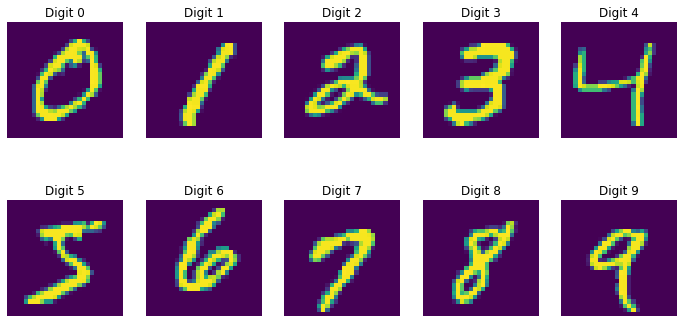

In [ ]:
# Define the digits to print original images for
digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Load MNIST dataset
mnist_dataset = MNIST(root='data/', download=True)

# Print original images for each digit
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    digit_indices = np.where(np.array(mnist_dataset.targets) == digits[i])[0]
    img = mnist_dataset.data[digit_indices[0]].numpy()
    ax.imshow(img)
    ax.set_title(f"Digit {i}")
    ax.axis('off')
plt.show()

#Question 3A: Classification image for each digit by white noise equation. First define a function for all the noise images.Then do a loop over for all the images to average them.

Number of images for digit 0: 500
500
Number of images for digit 1: 500
500
Number of images for digit 2: 500
500
Number of images for digit 3: 500
500
Number of images for digit 4: 500
500
Number of images for digit 5: 500
500
Number of images for digit 6: 500
500
Number of images for digit 7: 500
500
Number of images for digit 8: 500
500
Number of images for digit 9: 500
500


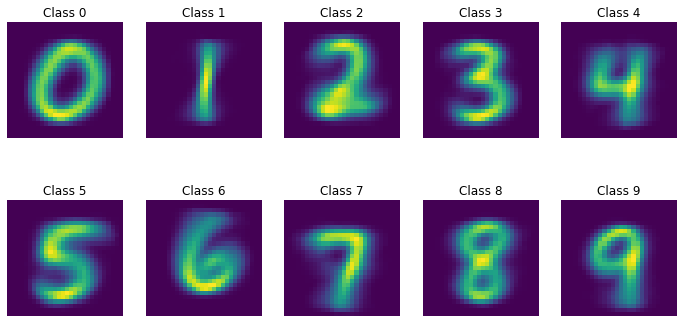

In [ ]:
# Define the gamma value
gamma = 0.2

# Define the number of samples and image shape
n_samples = 500
img_shape = (28, 28)

# Define the digits to generate noise maps for
digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def generate_noise_maps_per_digit(digit, n_samples, gamma, img_shape=(28, 28)):
    noise_maps = []
    mnist_dataset = MNIST(root='data/',train=False, download=True)
    digit_indices = np.where(np.array(mnist_dataset.targets) == digit)[0]
    digit_indices = digit_indices[:n_samples]
    print(f"Number of images for digit {digit}: {len(digit_indices)}")
    sample_size= len(digit_indices)
    print(sample_size)
    for idx in digit_indices:
        # Get original image
        img = mnist_dataset.data[idx].numpy()
        # Generate random noise
        noise = np.random.randn(*img_shape)
        # Combine noise with original image
        noisy_img = gamma * noise + (1 - gamma) * img
        noise_maps.append(noisy_img)
    return np.array(noise_maps) , sample_size

# Generate noise maps for each digit and average them
noise_maps=[]
avgd_noise_maps = []
for digit in digits:
    digit_noise_maps, sample_size = generate_noise_maps_per_digit(digit, n_samples, gamma, img_shape=(28,28))
    avg_noise_map = np.mean(digit_noise_maps, axis=0)
    avgd_noise_maps.append(avg_noise_map)
    noise_maps.append(digit_noise_maps)

all_noise_maps = np.concatenate(noise_maps)
    

# Plot the noise maps
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    ax.imshow(avgd_noise_maps[i])
    ax.set_title(f"Class {i}")
    ax.axis('off')
plt.show()


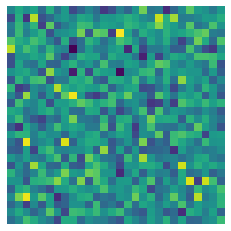

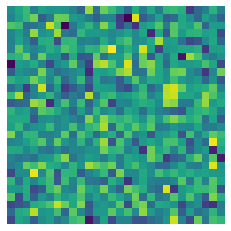

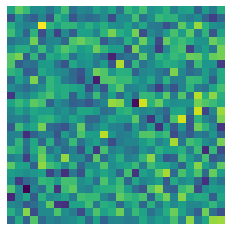

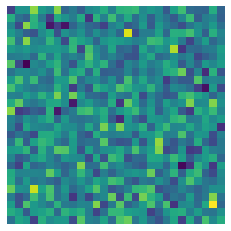

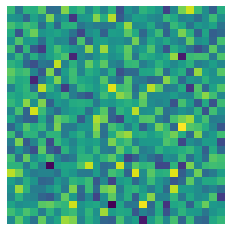

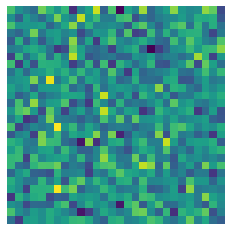

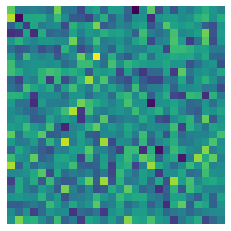

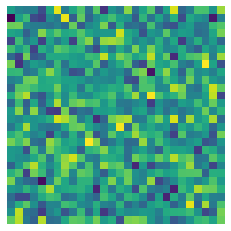

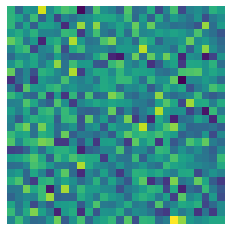

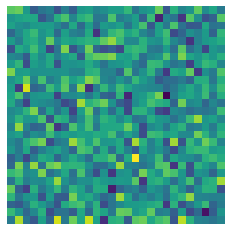

In [ ]:
def generate_noise_maps(n_samples, gamma, img_shape=(28, 28)):
    noise_maps = []
    for _ in range(n_samples):
        # Generate random noise
        noise = np.random.randn(*img_shape)
        # Combine noise with original image
        noisy_img = gamma * noise + (1 - gamma) * np.ones(img_shape)
        noise_maps.append(noisy_img)
    return np.array(noise_maps)

# assuming `noisy_images` is a list of numpy arrays with shape (28, 28)
for i in range(len(generate_noise_maps(10,0.4, img_shape=(28, 28)))):
    fig, ax = plt.subplots()
    ax.imshow(generate_noise_maps(10,0.1, img_shape=(28, 28))[i])
    ax.axis('off')
    plt.show()

#Train the model and test on MNIST test dataset 

In [ ]:
# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# Reshape and normalize data
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32') / 255.0

# Define the model
Net = keras.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

# Compile the model
Net.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
]

# Train the model
history = Net.fit(train_images, train_labels, epochs=20, validation_data=(test_images, test_labels), callbacks=callbacks)

# Load best weights
Net.load_weights('best_model.h5')


Epoch 1/20
1875/1875 [==============================] - 130s 69ms/step - loss: 0.1141 - accuracy: 0.9646 - val_loss: 0.0391 - val_accuracy: 0.9874
Epoch 2/20
1875/1875 [==============================] - 126s 67ms/step - loss: 0.0366 - accuracy: 0.9887 - val_loss: 0.0324 - val_accuracy: 0.9899
Epoch 3/20
1875/1875 [==============================] - 126s 67ms/step - loss: 0.0276 - accuracy: 0.9912 - val_loss: 0.0391 - val_accuracy: 0.9876
Epoch 4/20
1875/1875 [==============================] - 126s 67ms/step - loss: 0.0208 - accuracy: 0.9937 - val_loss: 0.0363 - val_accuracy: 0.9892
Epoch 5/20
1875/1875 [==============================] - 123s 66ms/step - loss: 0.0164 - accuracy: 0.9948 - val_loss: 0.0359 - val_accuracy: 0.9901
Epoch 6/20
1875/1875 [==============================] - 130s 69ms/step - loss: 0.0136 - accuracy: 0.9955 - val_loss: 0.0289 - val_accuracy: 0.9923
Epoch 7/20
1875/1875 [==============================] - 130s 69ms/step - loss: 0.0123 - accuracy: 0.9961 - val_loss: 0

In [ ]:
# Define the model architecture
Net = keras.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

# Compile the model
Net.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Load best weights
Net.load_weights('best_model.h5')


#3B Feed the average noise map back in to the CNN and report which class they are classified as

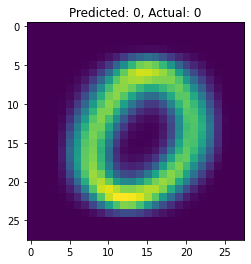

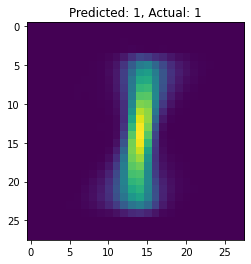

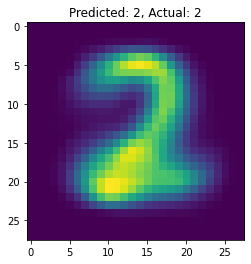

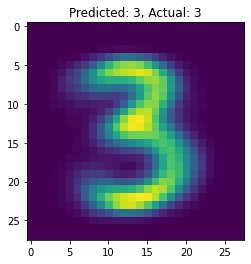

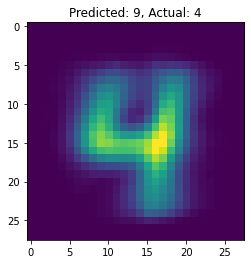

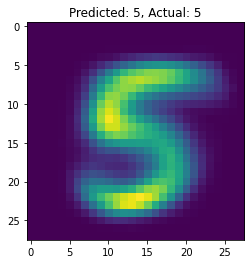

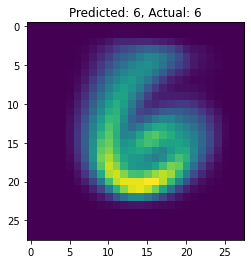

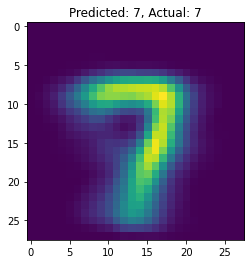

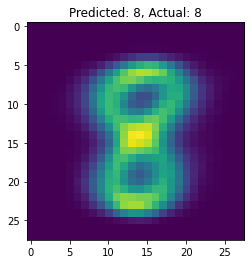

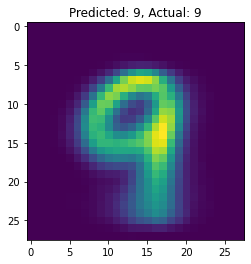

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       0.50      1.00      0.67         1

    accuracy                           0.90        10
   macro avg       0.85      0.90      0.87        10
weighted avg       0.85      0.90      0.87        10

Accuracy: 0.9


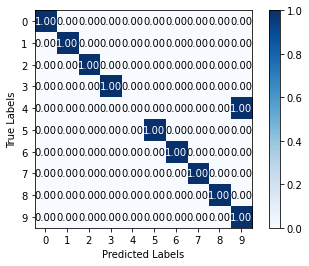

In [ ]:
# Define the number of samples and image shape
n_samples = 500
img_shape = (28, 28)

# Define the digits to generate noise maps for
digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Define the threshold for predictions
threshold = 0.2
# Get the predicted labels and true labels
y_pred = []
y_true = []
for digit in digits:
    test_tensor = tf.convert_to_tensor((avgd_noise_maps[digit])[None,...], dtype=tf.float32)
    output = Net(test_tensor)

    # Get the predicted class and corresponding probability
    probs = tf.nn.softmax(output, axis=1)
    max_prob = tf.reduce_max(probs, axis=1)
    pred_class = tf.argmax(probs, axis=1)
    
    # Filter out predictions with low confidence
    if tf.greater_equal(max_prob, threshold):
        # Convert the noise map to an image
        noise_map = avgd_noise_maps[digit]
        img = (noise_map * 255)
        # Append the predicted and true labels
        y_pred.append(pred_class.numpy()[0])
        y_true.append(digit)
         # Display the image with the predicted and actual class labels
        plt.imshow(img)
        plt.title(f"Predicted: {pred_class.numpy()[0]}, Actual: {digit}")
        plt.show()

        

# Generate the classification report
report = classification_report(y_true, y_pred)
print(report)


# Calculate the accuracy score
accuracy = accuracy_score(y_true, y_pred)
print('Accuracy:', accuracy)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')

# Plot the confusion matrix
plt.imshow(cm, cmap='Blues')
plt.colorbar()

# Add labels to the plot
classes = [str(i) for i in range(10)]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add values to the plot
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

# Show the plot
plt.show()


       


#3C Using all the noise maps as a classifier and report the accuracy scores across all classes with confusion matrices. Net model does a better job than Author's model which has less convolutional layer. 

Accuracy: 0.9842


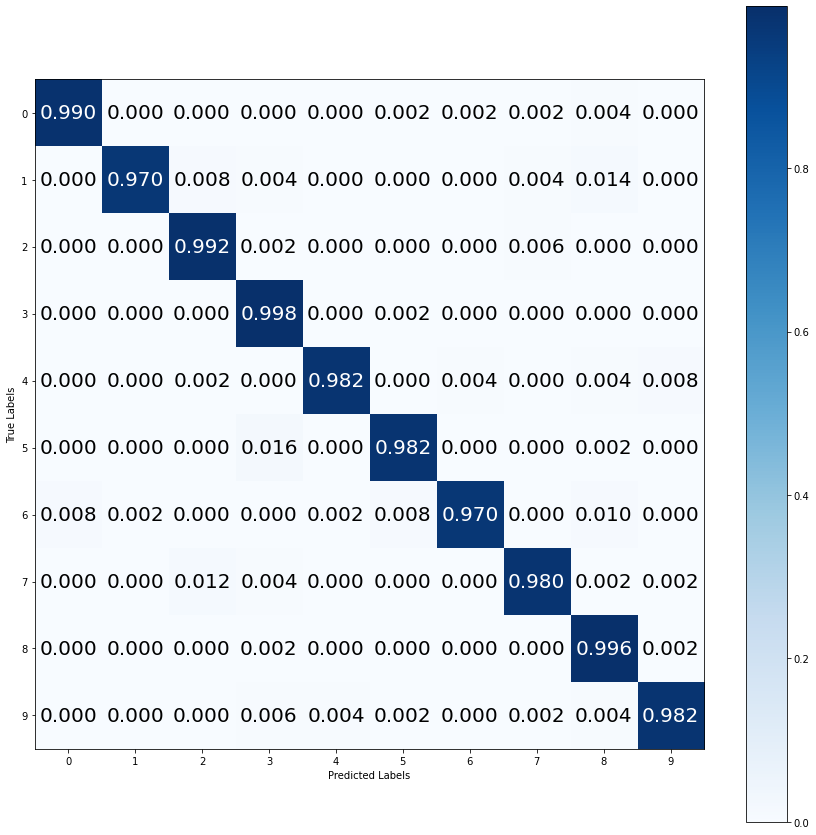

In [ ]:
# Define the number of samples and image shape
n_samples = 500
img_shape = (28, 28)

# Define the digits to generate noise maps for
digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Define the threshold for predictions
threshold = 0.01
# Get the predicted labels and true labels
y_pred = []
y_true = []

for i in range(all_noise_maps.shape[0]):
    test_tensor = tf.convert_to_tensor((all_noise_maps[i])[None,...], dtype=tf.float32)
    outputs = Net(test_tensor)
    #prob = torch.softmax(outputs, dim=1)
    # Get the predicted class and corresponding probability
    probs = tf.nn.softmax(outputs, axis=1)
    max_prob = tf.reduce_max(probs, axis=1)
    pred_class = tf.argmax(probs, axis=1)
    #max_prob, predicted_label = torch.max(prob.data, 1)
    if tf.greater(max_prob, tf.constant(threshold)):
       true_label = i // n_samples  # Get the true label from the digit index
       y_true.append(true_label)
       y_pred.append(pred_class.numpy()[0])


# Generate the classification report
#report = classification_report(y_true, y_pred)
#print(report)


# Calculate the accuracy score
accuracy = accuracy_score(y_true, y_pred)
print('Accuracy:', accuracy)

# Generate the confusion matrix
#num_classes = 10
#cm = np.zeros((num_classes, num_classes))
#for i in range(len(true_labels)):
 #   cm[true_labels[i], predicted_labels[i]] += 1

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')

# Set figure size
plt.figure(figsize=(15, 15))

# Plot the confusion matrix
plt.imshow(cm, cmap='Blues')
plt.colorbar()

# Add labels to the plot
classes = [str(i) for i in range(10)]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

if cm.size > 0:
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], '.3f'), fontsize=20,
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")


# Show the plot
plt.show()



In [ ]:
# Generate the classification report
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       500
           1       1.00      0.97      0.98       500
           2       0.98      0.99      0.99       500
           3       0.97      1.00      0.98       500
           4       0.99      0.98      0.99       500
           5       0.99      0.98      0.98       500
           6       0.99      0.97      0.98       500
           7       0.99      0.98      0.98       500
           8       0.96      1.00      0.98       500
           9       0.99      0.98      0.98       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



#3C  Note: Below is the confusion matrix for whole **MNIST dataset** as a test data

938/938 [==============================] - 36s 38ms/step - loss: 0.0020 - accuracy: 0.9993


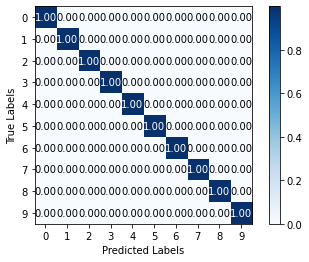

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5923
           1       1.00      1.00      1.00      6742
           2       1.00      1.00      1.00      5958
           3       1.00      1.00      1.00      6131
           4       1.00      1.00      1.00      5842
           5       1.00      1.00      1.00      5421
           6       1.00      1.00      1.00      5918
           7       1.00      1.00      1.00      6265
           8       1.00      1.00      1.00      5851
           9       1.00      1.00      1.00      5949

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000



In [ ]:
# Compile the model
#net.compile(optimizer='adam',
 #             loss='sparse_categorical_crossentropy',
 #             metrics=['accuracy'])

# Load the test dataset
(test_images, test_labels), _ = tf.keras.datasets.mnist.load_data()
test_dataset = tf.data.Dataset.from_tensor_slices((test_images[..., tf.newaxis]/255.0, test_labels))
test_dataset = test_dataset.batch(64)

# Set the model to evaluation mode
Net.evaluate(test_dataset)

# Get the true labels and predicted labels for the test set
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    outputs = Net(images)
    predicted = tf.argmax(outputs, axis=1)
    true_labels += labels.numpy().tolist()
    predicted_labels += predicted.numpy().tolist()

# Generate the confusion matrix
num_classes = 10
cm = np.zeros((num_classes, num_classes))
for i in range(len(true_labels)):
    cm[true_labels[i], predicted_labels[i]] += 1

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.imshow(cm, cmap='Blues')
plt.colorbar()

# Add labels to the plot
classes = [str(i) for i in range(10)]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add values to the plot
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

# Show the plot
plt.show()


# Generate the classification report
report = classification_report(true_labels, predicted_labels)
print(report)

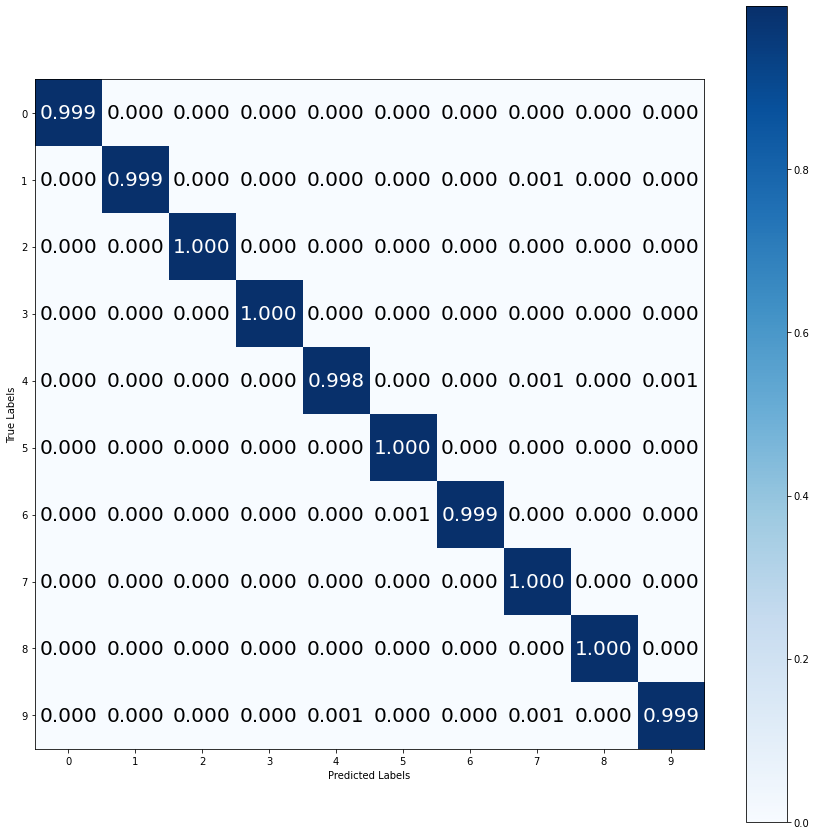

In [ ]:
# Set figure size
plt.figure(figsize=(15, 15))

# Generate the confusion matrix
num_classes = 10
cm = np.zeros((num_classes, num_classes))
for i in range(len(true_labels)):
    cm[true_labels[i], predicted_labels[i]] += 1

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.imshow(cm, cmap='Blues')
plt.colorbar()

# Add labels to the plot
classes = [str(i) for i in range(10)]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add values to the plot
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], '.3f'), fontsize=20,
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

# Show the plot
plt.show()
